# 01_data_qc.ipynb


In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().resolve()
if (ROOT / "src").exists():
    sys.path.insert(0, str(ROOT))
else:
    sys.path.insert(0, str(ROOT.parent))

# 02_calibrate_basecorr.ipynb


ModuleNotFoundError: No module named 'src'

# 02_calibrate_basecorr

Calibrate a base correlation smile for one tenor and visualize the result.


In [2]:
import pandas as pd
from src.calibration_basecorr import calibrate_basecorr_from_quotes
from src.curves import build_index_curve


index_df = pd.read_csv("/Users/ginachen/Desktop/CDX-Tranche-Pricing/cdx-engine/data/cdx_timeseries.csv", parse_dates=["Date"])
index_df["Tenor"] = index_df["Tenor"].astype(str).str.upper()
index_df["tenor"] = index_df["Tenor"].str.replace("Y", "", regex=False).astype(float)

num_cols = [
    "Index_Mid",
    "Equity_0_3_Spread",
    "Equity_0_3_Upfront",
    "Mezz_3_7_Spread",
    "Mezz_3_7_Upfront",
    "Mezz_7_10_Spread",
]
for col in num_cols:
    index_df[col] = pd.to_numeric(index_df[col], errors="coerce")

latest_date = index_df["Date"].max()
date_slice = index_df[index_df["Date"] == latest_date]

tenors = date_slice["tenor"].tolist()
index_spreads = (date_slice["Index_Mid"] / 10000.0).tolist()
curve = build_index_curve(tenors, index_spreads, recovery=0.4)

row_5y = date_slice[date_slice["Tenor"] == "5Y"].iloc[0]

tranche_spreads = {
    0.03: row_5y["Equity_0_3_Spread"] / 10000.0,
    0.07: row_5y["Mezz_3_7_Spread"] / 10000.0,
    0.10: row_5y["Mezz_7_10_Spread"] / 10000.0,
}
tranche_upfronts = {
    0.03: row_5y["Equity_0_3_Upfront"] / 100.0,
    0.07: row_5y["Mezz_3_7_Upfront"] / 100.0,
}

basecorr = calibrate_basecorr_from_quotes(
    5.0,
    [0.03, 0.07, 0.10],
    tranche_spreads,
    tranche_upfronts,
    curve,
    0.4,
    grid_size=51,
    n_quad=16,
)

print(latest_date.date(), basecorr)

2024-12-03 {0.03: 0.7920318242856844, 0.07: 0.5779121234175512, 0.1: 0.7105322692331371}


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from src.calibration_basecorr import calibrate_basecorr_curve
from src.curves import Curve
from src.pricer_tranche import price_tranche_lhp



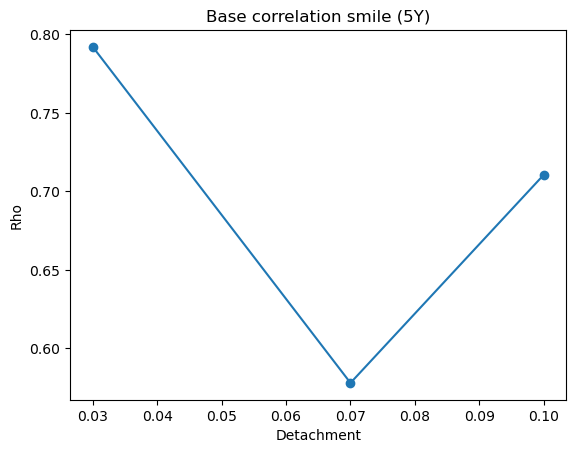

In [4]:
import matplotlib.pyplot as plt

dets = sorted(basecorr.keys())
vals = [basecorr[k] for k in dets]
plt.plot(dets, vals, marker="" \
"o")
plt.title("Base correlation smile (5Y)")
plt.xlabel("Detachment")
plt.ylabel("Rho")
plt.show()


In [5]:

import argparse
from datetime import date as date_type
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.calibration_basecorr import calibrate_basecorr_from_quotes
from src.curves import build_index_curve


def _parse_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser(description="Plot base correlation surface from CDX time series data.")
    parser.add_argument("--date", type=str, default=None, help="Date to plot (YYYY-MM-DD). Defaults to latest.")
    parser.add_argument("--n-quad", type=int, default=32, help="Gauss-Hermite nodes for pricing.")
    parser.add_argument("--grid-size", type=int, default=101, help="Grid size for bracketing search.")
    return parser.parse_args()


def _coerce_numeric(df: pd.DataFrame, cols: List[str]) -> None:
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")


def _build_curve(index_df: pd.DataFrame, snapshot: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    tenors = snapshot["tenor"].to_numpy(dtype=float)
    index_spreads = (snapshot["Index_Mid"].to_numpy(dtype=float)) / 10000.0
    curve = build_index_curve(tenors, index_spreads, recovery=0.4)
    return tenors, curve


def _row_quotes(row: pd.Series) -> tuple[Dict[float, float], Dict[float, float], List[float]]:
    tranche_spreads = {
        0.03: row["Equity_0_3_Spread"] / 10000.0,
        0.07: row["Mezz_3_7_Spread"] / 10000.0,
        0.10: row["Mezz_7_10_Spread"] / 10000.0,
        0.15: row["Senior_10_15_Spread"] / 10000.0,
        1.00: row["SuperSenior_15_100_Spread"] / 10000.0,
    }
    tranche_upfronts = {
        0.03: row["Equity_0_3_Upfront"] / 100.0,
        0.07: row["Mezz_3_7_Upfront"] / 100.0,
    }
    dets = [0.03, 0.07, 0.10, 0.15, 1.00]
    return tranche_spreads, tranche_upfronts, dets


def main() -> None:
    args = _parse_args()

    index_df = pd.read_csv("data/cdx_timeseries.csv", parse_dates=["Date"])
    index_df["Tenor"] = index_df["Tenor"].astype(str).str.upper()
    index_df["tenor"] = index_df["Tenor"].str.replace("Y", "", regex=False).astype(float)

    numeric_cols = [
        "Index_Mid",
        "Equity_0_3_Spread",
        "Equity_0_3_Upfront",
        "Mezz_3_7_Spread",
        "Mezz_3_7_Upfront",
        "Mezz_7_10_Spread",
        "Senior_10_15_Spread",
        "SuperSenior_15_100_Spread",
    ]
    _coerce_numeric(index_df, numeric_cols)

    if args.date:
        target_date = pd.to_datetime(args.date).date()
    else:
        target_date = index_df["Date"].max().date()

    snapshot = index_df[index_df["Date"].dt.date == target_date].copy()
    if snapshot.empty:
        raise SystemExit(f"No rows found for date {target_date}.")

    tenors, curve = _build_curve(index_df, snapshot)

    tenors_sorted = np.sort(tenors)
    dets = [0.03, 0.07, 0.10, 0.15, 1.00]
    surface = np.full((len(dets), len(tenors_sorted)), np.nan, dtype=float)

    for j, tenor in enumerate(tenors_sorted):
        row = snapshot[snapshot["tenor"] == tenor].iloc[0]
        tranche_spreads, tranche_upfronts, dets = _row_quotes(row)
        try:
            basecorr = calibrate_basecorr_from_quotes(
                tenor,
                dets,
                tranche_spreads,
                tranche_upfronts,
                curve,
                recovery=0.4,
                grid_size=args.grid_size,
                n_quad=args.n_quad,
            )
        except ValueError:
            continue

        for i, det in enumerate(dets):
            surface[i, j] = basecorr.get(det, np.nan)

    T, D = np.meshgrid(tenors_sorted, dets)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(T, D * 100.0, surface, cmap="viridis", edgecolor="k", linewidth=0.3)

    ax.set_title(f"Base Correlation Surface: {target_date}")
    ax.set_xlabel("Tenor (Years)")
    ax.set_ylabel("Detachment (%)")
    ax.set_zlabel("Base Correlation")
    fig.colorbar(surf, shrink=0.6, label="Base Correlation")

    plt.tight_layout()
    plt.show()




In [6]:
import numpy as np
import matplotlib.pyplot as plt

from src.calibration_basecorr import calibrate_basecorr_curve
from src.curves import Curve
from src.pricer_tranche import price_tranche_lhp

# Example curve (placeholder)
curve = Curve(times=[5.0], hazard=[0.02])
recovery = 0.4

# Example market PVs for detachments
detachments = [0.03, 0.07, 0.1]
market_pvs = {0.03: 0.001, 0.07: 0.0025, 0.1: 0.003}

basecorr = calibrate_basecorr_curve(5.0, detachments, market_pvs, curve, recovery)
print(basecorr)


ValueError: Target PV not bracketed within rho bounds (0.0001, 0.999) for det=0.03. Objective range ≈ [-0.138454, -0.00547103].

In [ ]:
# Verify calibration by re-pricing
recovery=0.4
for det in dets:
    k1 = 0.0 if det == dets[0] else dets[dets.index(det) - 1]
    pv = price_tranche_lhp(5.0, k1, det, basecorr[det], curve, recovery).pv
    print(det, pv, market_pvs[det])


# 03_surface_and_bespoke.ipynb


# 03_surface_and_bespoke

Build a base correlation surface and price bespoke tranches.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from src.interpolation import build_rho_surface
from src.curves import Curve
from src.pricer_tranche import price_tranche_lhp

basecorr_by_tenor = {
    5.0: {0.03: 0.2, 0.07: 0.25, 0.1: 0.3},
    7.0: {0.03: 0.22, 0.07: 0.27, 0.1: 0.32},
}

rho_surface = build_rho_surface(basecorr_by_tenor)
curve = Curve(times=[5.0, 7.0], hazard=[0.02, 0.025])
recovery = 0.4


In [ ]:
tenors = np.linspace(5.0, 7.0, 10)
dets = np.linspace(0.03, 0.1, 10)

Z = np.array([[rho_surface(t, k) for k in dets] for t in tenors])
plt.imshow(Z, extent=[dets.min(), dets.max(), tenors.min(), tenors.max()], aspect="auto", origin="lower")
plt.colorbar(label="rho")
plt.xlabel("Detachment")
plt.ylabel("Tenor")
plt.title("Base correlation surface")
plt.show()


In [ ]:
# Bespoke pricing example
T = 6.0
K1, K2 = 0.03, 0.08
rho = rho_surface(T, K2)
tranche_pv = price_tranche_lhp(T, K1, K2, rho, curve, recovery).pv
print(f"Bespoke PV: {tranche_pv:.6f}")


# 04_dv01_hedge.ipynb


# 04_dv01_hedge

Compute tranche DV01 and hedge ratios with a 1bp bump.


In [ ]:
from src.curves import Curve
from src.risk import compute_dv01

curve = Curve(times=[5.0], hazard=[0.02])
recovery = 0.4

result = compute_dv01(5.0, 0.03, 0.07, 0.25, curve, recovery, bump_bp=1.0)
print(result)
print(f"hedge ratio: {result.hedge_ratio:.4f}")


In [ ]:
# Sensitivity sweep
import numpy as np
import matplotlib.pyplot as plt

rhos = np.linspace(0.1, 0.5, 9)
dv01s = [compute_dv01(5.0, 0.03, 0.07, rho, curve, recovery, bump_bp=1.0).tranche_dv01 for rho in rhos]
plt.plot(rhos, dv01s, marker="o")
plt.title("Tranche DV01 vs rho")
plt.xlabel("rho")
plt.ylabel("tranche DV01")
plt.show()
